In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import experimental, Conv2D, MaxPooling2D, Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
	"../leaves/images/", 
	shuffle = True, 
	image_size = (IMAGE_SIZE, IMAGE_SIZE), 
	batch_size = BATCH_SIZE
)

Found 7221 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
len(class_names)

8

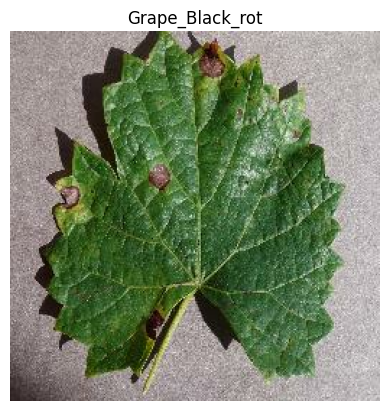

In [5]:
for image_batch, label_batch in dataset.take(1):
	plt.imshow(image_batch[0].numpy().astype("uint8"))
	plt.title(class_names[label_batch[0]])
	plt.axis("off")

In [6]:
len(dataset)

226

In [7]:
def get_dataset_partition_tf(ds, train_split = 0.8, cv_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
	if shuffle:
		ds = ds.shuffle(shuffle_size, seed = 12)
	
	len_train_dataset = int(len(ds) * train_split)
	len_cv = int(len(ds) * cv_split)
	train_dataset = ds.take(len_train_dataset)
	cv_dataset = ds.skip(len_train_dataset).take(len_cv)
	test_dataset = ds.skip(len_train_dataset + len_cv)
	return train_dataset, cv_dataset, test_dataset

In [8]:
train_ds, cv_ds, test_ds = get_dataset_partition_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
cv_ds = cv_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = Sequential([
	experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
	experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = Sequential([
	experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
	experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)


# Charger le modèle
model = load_model('mon_cnn_model.keras')
# model = Sequential([
# 	resize_and_rescale, 
# 	data_augmentation, 
# 	Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
# 	MaxPooling2D((2,2)),

# 	Conv2D(32, (3,3),  activation = 'relu'),
# 	MaxPooling2D((2,2)),

# 	Flatten(),
# 	Dense(64, activation = 'relu'), 
# 	Dense(len(class_names), activation = 'softmax')
# ])

In [13]:
# model.build(input_shape = input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                 

In [14]:
# model.compile(
# 	loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
# 	optimizer = 'adam',
# 	metrics = ['accuracy'])

In [15]:
# history = model.fit(
# 	train_ds, 
# 	epochs = EPOCHS, 
# 	batch_size = BATCH_SIZE, 
# 	verbose = 1, 
# 	validation_data = cv_ds
# )

(-0.5, 255.5, 255.5, -0.5)

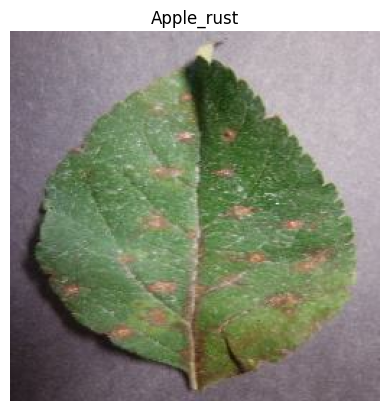

In [16]:
for image_batch, label_batch in dataset.take(1):
	image_to_test = image_batch[0].numpy().astype("uint8")
	label_image_to_test = label_batch[0]

plt.imshow(image_to_test)
plt.title(class_names[label_image_to_test])
plt.axis("off")

In [17]:
y_pred = model.predict(image_to_test.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3))
predicted_class = np.argmax(y_pred)
print("Prediction :",class_names[predicted_class])

1/1 [==============================] - 0s 54ms/step
Prediction : Apple_rust


In [18]:
# Sauvegarder le modèle
# model.save('mon_cnn_model.keras')

# Visualisation des calques intermediaires

In [24]:
# Création d'un nouveau modèle qui prend la même entrée que le modèle d'origine, mais renvoie les sorties du premier filtre Conv2D
activation_model = Model(inputs=model.input, outputs=model.layers[2].output)
image_to_test_bis = image_to_test.reshape((1,) + image_to_test.shape)


# Obtenez les activations du premier filtre Conv2D pour l'exemple donné
activations = activation_model.predict(image_to_test_bis)


1/1 [==============================] - 0s 31ms/step


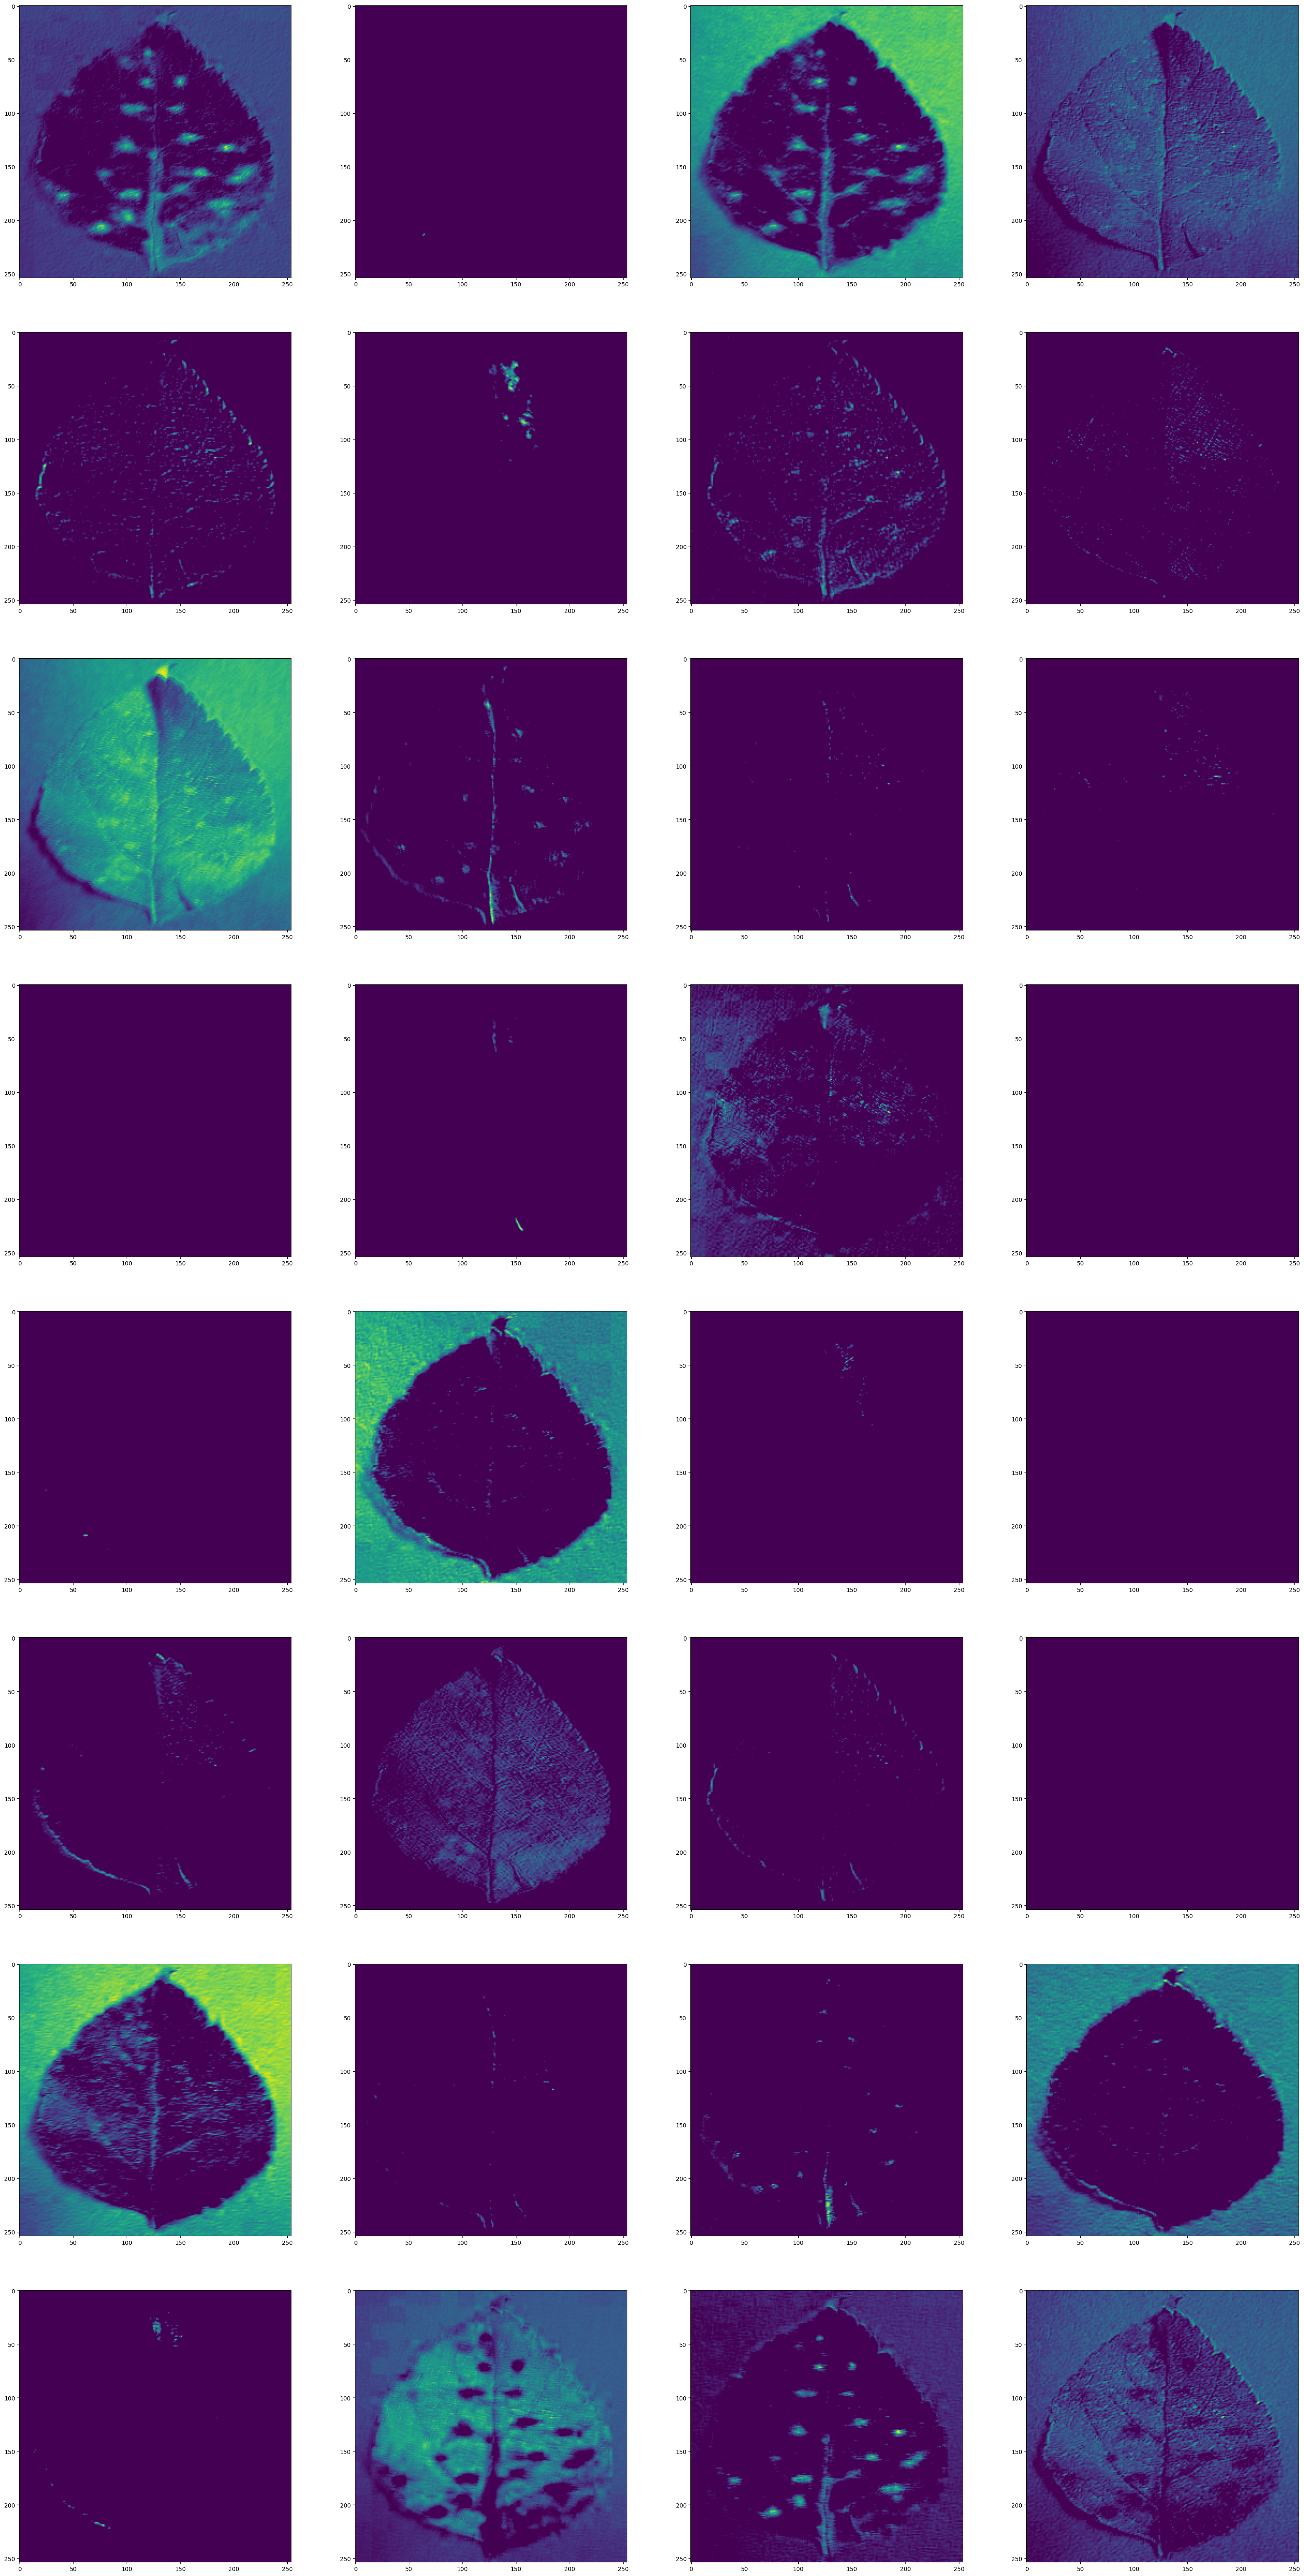

In [25]:

nb_col_graph = 4
nb_lignes_graph = 8
plt.figure(figsize=(nb_col_graph * 10, nb_lignes_graph * 10))
for i in range(32):
    plt.subplot(nb_lignes_graph, nb_col_graph, i + 1)
    plt.imshow(activations[0, :, :, i])  # Vous pouvez changer 'viridis' par une autre colormap
plt.show()